# 异质化蚁群优化算法：北京大学校园路径规划

该Notebook实现了基于异质化蚁群的路径优化算法，核心特性包括：

1. **异质化蚁群系统**：实现侦察蚁-觅食蚁模型
2. **动态任务分配**：基于响应阈值的自适应角色转换
3. **个体差异性**：每只蚂蚁具有独特的响应阈值
4. **可视化分析**：实时展示算法演进过程

## 1. 环境设置与参数配置

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from IPython.display import display, clear_output

# Matplotlib 中文显示设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 地图文件路径
MAP_IMAGE_PATH = 'map_1.0.jpg'

# 北京大学地点坐标
CITIES = {
    "West Gate": (703, 595),
    "Weiming Lake": (1069, 630), 
    "Jing Yuan": (928, 830),
    "Boya Tower": (1148, 646),
    "Statue of the Former Principal Cai Yuanpei": (885, 632),
    "Zhibeizi Garden": (1320, 1052),
    "YANNANYUAN": (969, 991),
    "May 4th Playground": (1251, 1147),
    "University Library": (1083, 816),
    "Stone Fish": (959, 632),
    "Tomb of Mr. Edgar Snow": (1070, 730),
    "Marble Boat": (1040, 571),
    "Luce Pavilion": (1012, 582),
    "Tian Yuan": (1314, 670),
    "MINGHE YUAN": (733, 518),
    "Campus Scenery Pavilion": (840, 470),
    "LANGRUN YUAN": (1134, 271),
    "JINGCHUN YUAN": (945, 455),
    "Lotus Pond": (750, 432),
    "SHAO HAI": (736, 742),
    "Catering Building": (939, 1111),
    "Humanities Garden": (1155, 433),
    "Statue of Professor Li Dazhao": (926, 738),
    "Museum of University History": (785,713),
    "University Hall": (1098, 992),
    "North Shore": (1049, 519),
    "The Bridge of Magpies": (993, 559),
    "Silent Wall": (1118, 503),
    "Fountain": (878, 1062),
    "Red Lake": (864, 419),
    "The Institute of Poetry Studies": (993, 358),
    "Tan Siu Lin Center for International Studies": (1080, 697)
    
}

# 基础算法参数
ANT_COUNT = 50
ITERATIONS = 100
RHO = 0.5  # 信息素蒸发率
Q = 100.0  # 信息素强度常数

# 异质化蚁群参数
ANT_CASTES = {
    'SCOUT': {  # 侦察蚁：专注于探索新路径
        'alpha': 0.5,    # 较低的信息素重要性
        'beta': 5.0,     # 较高的启发式重要性
        'ratio': 0.3,    # 初始占比30%
        'color': '#4CAF50',  # 绿色 - 探索
        'description': '侦察蚁：探索新路径，防止算法过早收敛'
    },
    'FORAGER': {  # 觅食蚁：专注于利用已知的好路径
        'alpha': 5.0,    # 较高的信息素重要性
        'beta': 0.5,     # 较低的启发式重要性
        'ratio': 0.7,    # 初始占比70%
        'color': '#2196F3',  # 蓝色 - 利用
        'description': '觅食蚁：利用已知好路径，加强优秀解的信息素'
    }
}

# 动态任务分配参数：基于响应阈值模型
STAGNATION_THRESHOLD_RANGE = (5, 15)  # 响应阈值范围
MAX_STAGNATION_FOR_CONVERSION = 20    # 最大停滞迭代数
CONVERSION_PROBABILITY = 0.3          # 转换概率

# 可视化参数
VISUALIZATION_OUTPUT_DIR = 'aco_visualization'
FRAME_INTERVAL = 5  # 每隔多少次迭代保存一张图片

## 2. 异质化蚁群算法实现

### 异质化蚁群的核心特性：

#### 侦察蚁 (Scout Ants)
- **低α值 (0.5)**：对现有信息素依赖较少
- **高β值 (5.0)**：更重视距离启发式信息
- **探索导向**：倾向于发现新路径

#### 觅食蚁 (Forager Ants)
- **高α值 (5.0)**：高度依赖信息素轨迹
- **低β值 (0.5)**：较少考虑距离因素
- **利用导向**：强化已知的优质路径

#### 动态任务分配机制
基于**响应阈值模型**，当算法停滞时，觅食蚁会转换为侦察蚁以增强探索能力。

In [2]:
class HeterogeneousAntColony:
    def __init__(self, cities, ant_count, rho, q):
        self.cities = cities
        self.city_names = list(cities.keys())
        self.city_coords = np.array(list(cities.values()))
        self.num_cities = len(cities)
        
        # 计算距离矩阵
        self.dist_matrix = self._calculate_dist_matrix()
        
        # 算法参数
        self.ant_count = ant_count
        self.rho = rho
        self.q = q
        
        # 初始化信息素和启发式信息
        self.pheromone = np.ones((self.num_cities, self.num_cities))
        self.heuristic = 1 / (self.dist_matrix + 1e-10)
        np.fill_diagonal(self.heuristic, 0)
        
        # 动态任务分配参数
        self.stagnation_counter = 0
        self.best_distance_history = []
        self.last_best_distance = float('inf')
        
        # 统计信息
        self.caste_statistics = {'SCOUT': 0, 'FORAGER': 0}

    def _calculate_dist_matrix(self):
        """计算城市间距离矩阵"""
        dist_matrix = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(i, self.num_cities):
                dist = np.linalg.norm(self.city_coords[i] - self.city_coords[j])
                dist_matrix[i, j] = dist_matrix[j, i] = dist
        return dist_matrix

    def _update_stagnation_counter(self, current_best_distance):
        """更新停滞计数器"""
        if current_best_distance < self.last_best_distance - 1e-6:
            self.stagnation_counter = 0
            self.last_best_distance = current_best_distance
            print(f"发现更优解！停滞计数器重置。新最优距离：{current_best_distance:.2f}")
        else:
            self.stagnation_counter += 1

    def _should_convert_to_scout(self, ant):
        """基于响应阈值模型决定蚂蚁是否应该转换为侦察蚁"""
        if ant['caste'] == 'SCOUT':
            return False
            
        # 检查是否超过该蚂蚁的响应阈值
        if self.stagnation_counter > ant['theta_threshold']:
            return True
            
        # 强制转换机制
        if self.stagnation_counter > MAX_STAGNATION_FOR_CONVERSION:
            return random.random() < CONVERSION_PROBABILITY
            
        return False

    def _select_next_city(self, ant, current_city):
        """选择下一个城市"""
        unvisited = [city for city in range(self.num_cities) if city not in ant['path']]
        if not unvisited:
            return None
            
        probabilities = []
        total_prob = 0

        alpha = ant['alpha']
        beta = ant['beta']
        
        for city in unvisited:
            pheromone = self.pheromone[current_city, city] ** alpha
            heuristic = self.heuristic[current_city, city] ** beta
            prob = pheromone * heuristic
            probabilities.append(prob)
            total_prob += prob
        
        if total_prob == 0:
            return random.choice(unvisited)
        
        probabilities = np.array(probabilities) / total_prob
        return np.random.choice(unvisited, p=probabilities)

    def _create_ants(self):
        """创建异质化蚂蚁群体"""
        ants = []
        
        scout_count = int(self.ant_count * ANT_CASTES['SCOUT']['ratio'])
        forager_count = self.ant_count - scout_count
        
        # 创建侦察蚁
        for _ in range(scout_count):
            start_city = random.randint(0, self.num_cities - 1)
            theta = random.uniform(*STAGNATION_THRESHOLD_RANGE)
            ants.append({
                'path': [start_city], 
                'distance': 0, 
                'caste': 'SCOUT',
                'alpha': ANT_CASTES['SCOUT']['alpha'],
                'beta': ANT_CASTES['SCOUT']['beta'],
                'theta_threshold': theta,
                'converted': False
            })
        
        # 创建觅食蚁
        for _ in range(forager_count):
            start_city = random.randint(0, self.num_cities - 1)
            theta = random.uniform(*STAGNATION_THRESHOLD_RANGE)
            ants.append({
                'path': [start_city], 
                'distance': 0, 
                'caste': 'FORAGER',
                'alpha': ANT_CASTES['FORAGER']['alpha'],
                'beta': ANT_CASTES['FORAGER']['beta'],
                'theta_threshold': theta,
                'converted': False
            })
                
        return ants

    def _update_pheromone(self, all_paths):
        """更新信息素"""
        self.pheromone *= (1 - self.rho)
        for ant in all_paths:
            for i in range(len(ant['path']) - 1):
                city1 = ant['path'][i]
                city2 = ant['path'][i+1]
                self.pheromone[city1, city2] += self.q / ant['distance']
                self.pheromone[city2, city1] += self.q / ant['distance']

    def path_distance(self, path):
        """计算路径总距离"""
        dist = 0
        for i in range(len(path) - 1):
            dist += self.dist_matrix[path[i], path[i+1]]
        if len(path) == self.num_cities:
            dist += self.dist_matrix[path[-1], path[0]]  # 回到起点
        return dist

    def plot(self, iteration, best_path, best_distance, all_paths):
        """绘制当前状态"""
        plt.figure(figsize=(15, 10))
        
        # 绘制地图背景
        try:
            campus_map = mpimg.imread(MAP_IMAGE_PATH)
            plt.imshow(campus_map, extent=[0, campus_map.shape[1], campus_map.shape[0], 0])
        except FileNotFoundError:
            print(f"警告: 地图文件 '{MAP_IMAGE_PATH}' 未找到")
        
        # 绘制信息素轨迹（使用冷色调）
        max_pheromone = self.pheromone.max()
        for i in range(self.num_cities):
            for j in range(i, self.num_cities):
                if self.pheromone[i, j] > 1:
                    alpha_val = min(0.6, (self.pheromone[i, j] / max_pheromone) * 1.2)
                    linewidth = min(2.0, self.pheromone[i,j]/max_pheromone * 3.0)  # 调细线条
                    plt.plot([self.city_coords[i, 0], self.city_coords[j, 0]], 
                             [self.city_coords[i, 1], self.city_coords[j, 1]], 
                             color='#B3E5FC', linewidth=linewidth,  # 浅蓝色信息素轨迹
                             alpha=alpha_val)

        # 绘制不同类型蚂蚁的路径
        caste_colors = {'SCOUT': ANT_CASTES['SCOUT']['color'], 'FORAGER': ANT_CASTES['FORAGER']['color']}
        caste_labels_added = set()
        
        for ant in all_paths:
            if len(ant['path']) > 1:
                path_coords = self.city_coords[ant['path']]
                caste_color = caste_colors[ant['caste']]
                caste_name = ant['caste']
                label_text = f"{caste_name}{'(转换)' if ant.get('converted', False) else ''}"
                
                if caste_name not in caste_labels_added:
                    plt.plot(path_coords[:, 0], path_coords[:, 1], color=caste_color, 
                            linestyle='--', linewidth=0.8, alpha=0.25, label=label_text)  # 调粗线条
                    caste_labels_added.add(caste_name)
                else:
                    plt.plot(path_coords[:, 0], path_coords[:, 1], color=caste_color, 
                            linestyle='--', linewidth=0.8, alpha=0.25)  # 调粗线条
        
        # 绘制最优路径（使用醒目的红色）
        if best_path and len(best_path) > 1:
            best_path_coords = self.city_coords[best_path + [best_path[0]]]
            plt.plot(best_path_coords[:, 0], best_path_coords[:, 1], color='#E91E63', 
                    linewidth=2.0, marker='o', markersize=3, label='当前最优路径')  # 调细线条和圆点

        # 绘制城市节点（调小圆点）
        plt.scatter(self.city_coords[:, 0], self.city_coords[:, 1], color='#1A237E', 
                   s=50, zorder=5, label='地点', edgecolors='white', linewidth=1)  # 深蓝色，调小圆点
        
        # 为最优路径添加访问顺序标号
        if best_path and len(best_path) > 1:
            for i, city_idx in enumerate(best_path):
                coord = self.city_coords[city_idx]
                plt.annotate(f'{i+1}', (coord[0], coord[1]), xytext=(5, 5), 
                            textcoords='offset points', fontsize=10, fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        # 移除景点名字的显示
        # for name, (x, y) in self.cities.items():
        #     plt.text(x, y-15, name, ha='center', va='bottom', fontsize=8, 
        #             color='#263238', weight='bold', bbox=dict(boxstyle='round,pad=0.2', 
        #             facecolor='white', alpha=0.8, edgecolor='none'))  # 文字样式优化

        title = f"迭代: {iteration} | 当前最优距离: {best_distance:.2f} | 停滞: {self.stagnation_counter}"
        plt.title(title, fontsize=14, weight='bold')
        plt.xlabel("X坐标", fontsize=12)
        plt.ylabel("Y坐标", fontsize=12)
        plt.legend(prop={'family': 'SimHei', 'size': 10}, framealpha=0.9) 
        
        # 保存图像
        if not os.path.exists(VISUALIZATION_OUTPUT_DIR):
            os.makedirs(VISUALIZATION_OUTPUT_DIR)
        filename = os.path.join(VISUALIZATION_OUTPUT_DIR, f'frame_{iteration:04d}.png')
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.show()

    def run(self, iterations):
        """运行异质化蚁群算法"""
        best_path = None
        best_distance = float('inf')
        history = []
        epoch_info = []  # 记录每个epoch的详细信息

        for i in range(iterations):
            all_paths = []
            ants = self._create_ants()
            
            # 重置统计
            self.caste_statistics = {'SCOUT': 0, 'FORAGER': 0}
            conversion_count = 0
            
            for ant in ants:
                # 检查是否需要动态转换角色
                if self._should_convert_to_scout(ant):
                    ant['original_caste'] = ant['caste']
                    ant['caste'] = 'SCOUT'
                    ant['alpha'] = ANT_CASTES['SCOUT']['alpha']
                    ant['beta'] = ANT_CASTES['SCOUT']['beta']
                    ant['converted'] = True
                    conversion_count += 1
                
                # 统计当前迭代的角色分布
                self.caste_statistics[ant['caste']] += 1
                
                # 构建路径
                for _ in range(self.num_cities - 1):
                    current_city = ant['path'][-1]
                    next_city = self._select_next_city(ant, current_city)
                    if next_city is not None:
                        ant['path'].append(next_city)
                
                path_dist = self.path_distance(ant['path'])
                ant['distance'] = path_dist
                all_paths.append(ant)

            # 更新信息素
            self._update_pheromone(all_paths)

            # 寻找当前迭代的最优路径
            current_best_ant = min(all_paths, key=lambda x: x['distance'])
            current_iteration_best = current_best_ant['distance']
            
            # 记录epoch信息
            epoch_info.append({
                'iteration': i,
                'best_distance': current_iteration_best,
                'global_best': best_distance,
                'scout_count': self.caste_statistics['SCOUT'],
                'forager_count': self.caste_statistics['FORAGER'],
                'conversions': conversion_count,
                'stagnation': self.stagnation_counter,
                'improvement': current_iteration_best < best_distance
            })
            
            if current_best_ant['distance'] < best_distance:
                best_distance = current_best_ant['distance']
                best_path = current_best_ant['path']
            
            # 更新停滞计数器
            self._update_stagnation_counter(best_distance)

            history.append(best_distance)
            
            # 可视化
            if i % FRAME_INTERVAL == 0:
                self.plot(i, best_path, best_distance, all_paths)

            clear_output(wait=True)
            status_msg = (f"迭代 {i+1}/{iterations} | 当前最优距离: {best_distance:.2f} | "
                         f"停滞: {self.stagnation_counter} | 侦察蚁: {self.caste_statistics['SCOUT']} | "
                         f"觅食蚁: {self.caste_statistics['FORAGER']}")
            print(status_msg)
        
        # 保存详细信息到实例中
        self.epoch_info = epoch_info
            
        return best_path, best_distance, history

    def plot_final_result(self, best_path, best_distance, all_paths):
        """绘制最终结果图"""
        plt.figure(figsize=(16, 12))
        
        # 绘制地图背景
        try:
            campus_map = mpimg.imread(MAP_IMAGE_PATH)
            plt.imshow(campus_map, extent=[0, campus_map.shape[1], campus_map.shape[0], 0])
        except FileNotFoundError:
            print(f"警告: 地图文件 '{MAP_IMAGE_PATH}' 未找到")
        
        # 绘制信息素轨迹
        max_pheromone = self.pheromone.max()
        for i in range(self.num_cities):
            for j in range(i, self.num_cities):
                if self.pheromone[i, j] > 1:
                    alpha_val = min(0.6, (self.pheromone[i, j] / max_pheromone) * 1.2)
                    linewidth = min(3.0, self.pheromone[i,j]/max_pheromone * 4.0)
                    plt.plot([self.city_coords[i, 0], self.city_coords[j, 0]], 
                             [self.city_coords[i, 1], self.city_coords[j, 1]], 
                             color='#B3E5FC', linewidth=linewidth,
                             alpha=alpha_val, label='信息素轨迹' if i == 0 and j == 1 else "")

        # 绘制最优路径（醒目显示）
        if best_path and len(best_path) > 1:
            best_path_coords = self.city_coords[best_path + [best_path[0]]]
            plt.plot(best_path_coords[:, 0], best_path_coords[:, 1], color='#E91E63', 
                    linewidth=4.0, marker='o', markersize=8, label=f'最优路径 (距离: {best_distance:.2f})',
                    markerfacecolor='white', markeredgecolor='#E91E63', markeredgewidth=2)

        # 绘制城市节点
        plt.scatter(self.city_coords[:, 0], self.city_coords[:, 1], color='#1A237E', 
                   s=100, zorder=5, label='地点', edgecolors='white', linewidth=2)
        
        # 标注起点
        if best_path:
            start_coord = self.city_coords[best_path[0]]
            plt.scatter(start_coord[0], start_coord[1], color='#4CAF50', s=200, 
                       marker='s', label='起点', zorder=6, edgecolors='white', linewidth=2)
        
        # 为最优路径添加访问顺序标号
        if best_path and len(best_path) > 1:
            for i, city_idx in enumerate(best_path):
                coord = self.city_coords[city_idx]
                plt.annotate(f'{i+1}', (coord[0], coord[1]), xytext=(5, 5), 
                            textcoords='offset points', fontsize=12, fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

        plt.title(f"异质化蚁群算法最终结果\n最优距离: {best_distance:.2f} | 停滞计数: {self.stagnation_counter}", 
                 fontsize=16, weight='bold')
        plt.xlabel("X坐标", fontsize=14)
        plt.ylabel("Y坐标", fontsize=14)
        plt.legend(prop={'family': 'SimHei', 'size': 12}, framealpha=0.9, loc='upper right') 
        
        # 保存最终结果图
        if not os.path.exists(VISUALIZATION_OUTPUT_DIR):
            os.makedirs(VISUALIZATION_OUTPUT_DIR)
        final_filename = os.path.join(VISUALIZATION_OUTPUT_DIR, 'final_result.png')
        plt.savefig(final_filename, dpi=200, bbox_inches='tight')
        plt.show()
        
        return final_filename

    def print_detailed_analysis(self, best_path, best_distance):
        """打印详细的结果分析"""
        print("\n" + "="*80)
        print("🏆 异质化蚁群算法 - 详细结果分析")
        print("="*80)
        
        # 最优路径信息
        if best_path:
            best_path_cities = [self.city_names[i] for i in best_path]
            print(f"\n📍 最优路径详情:")
            print(f"   总距离: {best_distance:.2f}")
            print(f"   访问地点数: {len(best_path)}")
            print(f"   路径: {' → '.join(best_path_cities[:5])}...")
            if len(best_path_cities) > 5:
                print(f"        ...{' → '.join(best_path_cities[-3:])}")
        
        # Epoch信息分析
        print(f"\n📊 训练过程分析:")
        improvement_epochs = [info for info in self.epoch_info if info['improvement']]
        conversion_epochs = [info for info in self.epoch_info if info['conversions'] > 0]
        
        print(f"   总迭代次数: {len(self.epoch_info)}")
        print(f"   发生改善的迭代: {len(improvement_epochs)} 次")
        print(f"   发生角色转换的迭代: {len(conversion_epochs)} 次")
        print(f"   最终停滞计数: {self.stagnation_counter}")
        
        # 关键改善点
        if improvement_epochs:
            print(f"\n🎯 关键改善节点:")
            for i, epoch in enumerate(improvement_epochs[:5]):  # 显示前5个改善点
                print(f"   第{epoch['iteration']:3d}迭代: {epoch['best_distance']:8.2f} "
                      f"(侦察蚁:{epoch['scout_count']:2d}, 觅食蚁:{epoch['forager_count']:2d})")
        
        # 角色转换分析
        total_conversions = sum(info['conversions'] for info in self.epoch_info)
        print(f"\n🔄 动态角色转换统计:")
        print(f"   总转换次数: {total_conversions}")
        print(f"   转换发生频率: {len(conversion_epochs)/len(self.epoch_info)*100:.1f}%")
        
        if conversion_epochs:
            print(f"   主要转换时期:")
            for epoch in conversion_epochs[:3]:
                print(f"   第{epoch['iteration']:3d}迭代: {epoch['conversions']}次转换 "
                      f"(停滞:{epoch['stagnation']})")
        
        # 收敛性分析
        distances = [info['best_distance'] for info in self.epoch_info]
        early_avg = np.mean(distances[:10]) if len(distances) >= 10 else distances[0]
        late_avg = np.mean(distances[-10:]) if len(distances) >= 10 else distances[-1]
        improvement_rate = (early_avg - late_avg) / early_avg * 100
        
        print(f"\n📈 收敛性能:")
        print(f"   初期平均距离: {early_avg:.2f}")
        print(f"   后期平均距离: {late_avg:.2f}")
        print(f"   总体改善率: {improvement_rate:.2f}%")
        
        # 信息素分布统计
        pheromone_stats = {
            'max': self.pheromone.max(),
            'min': self.pheromone.min(),
            'mean': self.pheromone.mean(),
            'std': self.pheromone.std()
        }
        
        print(f"\n🧪 信息素分布:")
        print(f"   最大值: {pheromone_stats['max']:.2f}")
        print(f"   最小值: {pheromone_stats['min']:.2f}")
        print(f"   平均值: {pheromone_stats['mean']:.2f}")
        print(f"   标准差: {pheromone_stats['std']:.2f}")
        
        print("\n" + "="*80)

    # ...existing code...

## 3. 运行异质化蚁群算法

迭代 100/100 | 当前最优距离: 3622.81 | 停滞: 32 | 侦察蚁: 50 | 觅食蚁: 0

=== 最终结果 ===
最优路径: University Library -> Tomb of Mr. Edgar Snow -> Tan Siu Lin Center for International Studies -> Weiming Lake -> Marble Boat -> Luce Pavilion -> The Bridge of Magpies -> North Shore -> Silent Wall -> Humanities Garden -> LANGRUN YUAN -> The Institute of Poetry Studies -> JINGCHUN YUAN -> Red Lake -> Campus Scenery Pavilion -> Lotus Pond -> MINGHE YUAN -> West Gate -> SHAO HAI -> Museum of University History -> Statue of the Former Principal Cai Yuanpei -> Stone Fish -> Statue of Professor Li Dazhao -> Jing Yuan -> YANNANYUAN -> Fountain -> Catering Building -> University Hall -> May 4th Playground -> Zhibeizi Garden -> Tian Yuan -> Boya Tower
最优距离: 3622.81
最终停滞计数: 32

🎨 生成最终结果图...


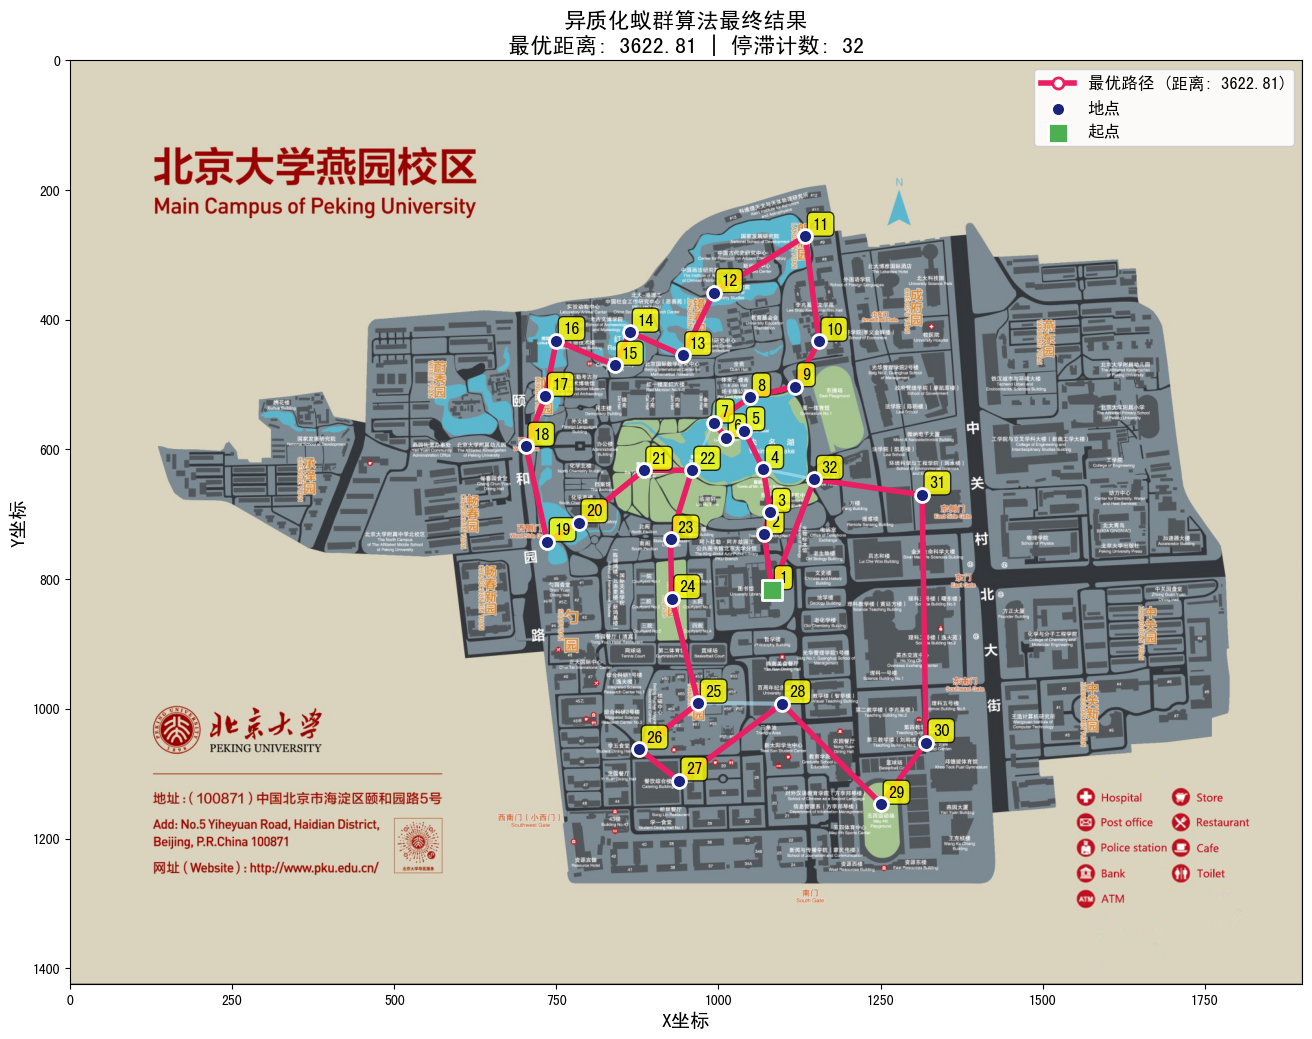


🏆 异质化蚁群算法 - 详细结果分析

📍 最优路径详情:
   总距离: 3622.81
   访问地点数: 32
   路径: University Library → Tomb of Mr. Edgar Snow → Tan Siu Lin Center for International Studies → Weiming Lake → Marble Boat...
        ...Zhibeizi Garden → Tian Yuan → Boya Tower

📊 训练过程分析:
   总迭代次数: 100
   发生改善的迭代: 6 次
   发生角色转换的迭代: 77 次
   最终停滞计数: 32

🎯 关键改善节点:
   第  0迭代:  4155.24 (侦察蚁:15, 觅食蚁:35)
   第  2迭代:  4018.41 (侦察蚁:15, 觅食蚁:35)
   第  3迭代:  3683.45 (侦察蚁:15, 觅食蚁:35)
   第  4迭代:  3665.40 (侦察蚁:15, 觅食蚁:35)
   第 19迭代:  3643.83 (侦察蚁:45, 觅食蚁: 5)

🔄 动态角色转换统计:
   总转换次数: 2225
   转换发生频率: 77.0%
   主要转换时期:
   第 11迭代: 2次转换 (停滞:6)
   第 12迭代: 7次转换 (停滞:7)
   第 13迭代: 12次转换 (停滞:8)

📈 收敛性能:
   初期平均距离: 3819.65
   后期平均距离: 3750.71
   总体改善率: 1.80%

🧪 信息素分布:
   最大值: 2.27
   最小值: 0.00
   平均值: 0.14
   标准差: 0.42


💾 文件保存信息:
   最终结果图: aco_visualization/final_result.png
   可视化序列: aco_visualization/frame_*.png


In [3]:
print("=== 异质化蚁群算法 ===\n")
print(f"侦察蚁数量: {int(ANT_COUNT * ANT_CASTES['SCOUT']['ratio'])} ({ANT_CASTES['SCOUT']['ratio']*100:.0f}%)")
print(f"觅食蚁数量: {int(ANT_COUNT * ANT_CASTES['FORAGER']['ratio'])} ({ANT_CASTES['FORAGER']['ratio']*100:.0f}%)")
print(f"停滞阈值范围: {STAGNATION_THRESHOLD_RANGE}")
print(f"最大停滞容忍: {MAX_STAGNATION_FOR_CONVERSION} 迭代\n")

print("异质化蚁群特性:")
for caste_name, caste_info in ANT_CASTES.items():
    print(f"  {caste_name}: {caste_info['description']}")
    print(f"    参数: α={caste_info['alpha']}, β={caste_info['beta']}")

# 创建算法实例
aco = HeterogeneousAntColony(
    cities=CITIES,
    ant_count=ANT_COUNT,
    rho=RHO,
    q=Q
)

# 运行算法
best_path_indices, best_distance, distance_history = aco.run(ITERATIONS)

# 输出最终结果
best_path_cities = [aco.city_names[i] for i in best_path_indices] if best_path_indices else []
print("\n=== 最终结果 ===")
if best_path_cities:
    print(f"最优路径: {' -> '.join(best_path_cities)}")
    print(f"最优距离: {best_distance:.2f}")
    print(f"最终停滞计数: {aco.stagnation_counter}")
else:
    print("未找到有效的路径")

# 绘制并保存最终结果图
print("\n🎨 生成最终结果图...")
final_image_path = aco.plot_final_result(best_path_indices, best_distance, [])

# 打印详细分析
aco.print_detailed_analysis(best_path_indices, best_distance)

print(f"\n💾 文件保存信息:")
print(f"   最终结果图: {final_image_path}")
print(f"   可视化序列: {VISUALIZATION_OUTPUT_DIR}/frame_*.png")

## 4. 算法性能分析

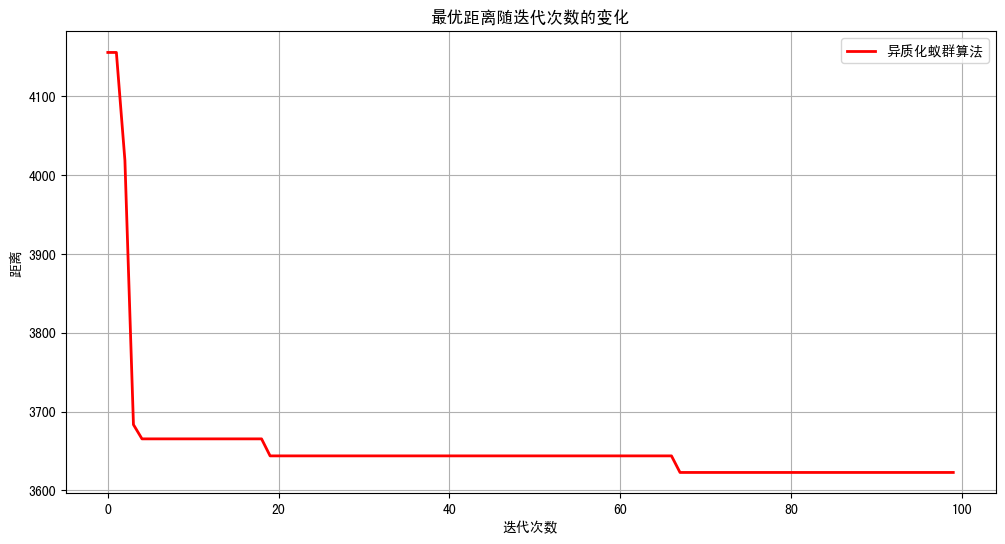


=== 异质化蚁群算法性能分析 ===
收敛特性分析:
  总迭代次数: 100
  发生改善的迭代: 5 次
  最后一次改善: 第 67 迭代
  最终停滞计数: 32
  收敛改善率: 4.67%

算法参数验证:
  侦察蚁 (α=0.5, β=5.0): 偏向探索
  觅食蚁 (α=5.0, β=0.5): 偏向利用
  动态转换机制: 停滞>5迭代时触发

可视化输出:
可视化图片已保存在 'aco_visualization' 文件夹中
您可以使用ffmpeg等工具将它们合成为视频

命令示例:
ffmpeg -r 10 -f image2 -i aco_visualization/frame_%04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p aco_heterogeneous.mp4


In [4]:
# 绘制收敛曲线
plt.figure(figsize=(12, 6))
plt.plot(distance_history, label='异质化蚁群算法', linewidth=2, color='red')
plt.title("最优距离随迭代次数的变化")
plt.xlabel("迭代次数")
plt.ylabel("距离")
plt.grid(True)
plt.legend()
plt.show()

# 性能分析
print("\n=== 异质化蚁群算法性能分析 ===")

# 分析收敛特性
improvement_iterations = []
for i in range(1, len(distance_history)):
    if distance_history[i] < distance_history[i-1] - 1e-6:
        improvement_iterations.append(i)

print(f"收敛特性分析:")
print(f"  总迭代次数: {len(distance_history)}")
print(f"  发生改善的迭代: {len(improvement_iterations)} 次")
print(f"  最后一次改善: 第 {improvement_iterations[-1] if improvement_iterations else 0} 迭代")
print(f"  最终停滞计数: {aco.stagnation_counter}")

# 统计收敛速度
if len(distance_history) > 10:
    early_avg = np.mean(distance_history[:10])
    late_avg = np.mean(distance_history[-10:])
    improvement_rate = (early_avg - late_avg) / early_avg * 100
    print(f"  收敛改善率: {improvement_rate:.2f}%")

print(f"\n算法参数验证:")
print(f"  侦察蚁 (α={ANT_CASTES['SCOUT']['alpha']}, β={ANT_CASTES['SCOUT']['beta']}): 偏向探索")
print(f"  觅食蚁 (α={ANT_CASTES['FORAGER']['alpha']}, β={ANT_CASTES['FORAGER']['beta']}): 偏向利用")
print(f"  动态转换机制: 停滞>{STAGNATION_THRESHOLD_RANGE[0]}迭代时触发")

print(f"\n可视化输出:")
print(f"可视化图片已保存在 '{VISUALIZATION_OUTPUT_DIR}' 文件夹中")
print("您可以使用ffmpeg等工具将它们合成为视频")
print("\n命令示例:")
print(f"ffmpeg -r 10 -f image2 -i {VISUALIZATION_OUTPUT_DIR}/frame_%04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p aco_heterogeneous.mp4")

## 5. 异质化蚁群特性验证

In [32]:
def demonstrate_heterogeneous_features():
    """展示异质化蚁群的核心特性"""
    print("=== 异质化蚁群特性演示 ===")
    
    # 创建测试实例
    test_aco = HeterogeneousAntColony(
        cities=CITIES,
        ant_count=20,  # 较小的蚂蚁数量便于观察
        rho=0.5,
        q=100
    )
    
    # 测试蚂蚁创建
    print("\n1. 蚂蚁群体组成:")
    ants = test_aco._create_ants()
    scout_count = sum(1 for ant in ants if ant['caste'] == 'SCOUT')
    forager_count = sum(1 for ant in ants if ant['caste'] == 'FORAGER')
    
    print(f"   侦察蚁数量: {scout_count} ({scout_count/len(ants)*100:.1f}%)")
    print(f"   觅食蚁数量: {forager_count} ({forager_count/len(ants)*100:.1f}%)")
    
    # 显示蚂蚁参数分布
    print("\n2. 蚂蚁参数分布:")
    for ant in ants[:5]:  # 只显示前5只蚂蚁
        print(f"   {ant['caste']}: α={ant['alpha']}, β={ant['beta']}, 阈值={ant['theta_threshold']:.1f}")
    
    # 模拟动态转换
    print("\n3. 动态转换机制测试:")
    test_aco.stagnation_counter = 0
    print(f"   初始停滞计数: {test_aco.stagnation_counter}")
    
    # 模拟停滞情况
    test_aco.stagnation_counter = 10
    print(f"   设置停滞计数为: {test_aco.stagnation_counter}")
    
    conversion_count = 0
    for ant in ants:
        if ant['caste'] == 'FORAGER' and test_aco._should_convert_to_scout(ant):
            conversion_count += 1
    
    print(f"   将被转换为侦察蚁的觅食蚁数量: {conversion_count}")
    
    # 参数影响分析
    print("\n4. 参数影响分析:")
    print(f"   侦察蚁 (α={ANT_CASTES['SCOUT']['alpha']}, β={ANT_CASTES['SCOUT']['beta']}):")
    print(f"     - 低α值使其对信息素依赖较少，更倾向于探索新路径")
    print(f"     - 高β值使其更注重距离启发式，选择距离短的路径")
    
    print(f"   觅食蚁 (α={ANT_CASTES['FORAGER']['alpha']}, β={ANT_CASTES['FORAGER']['beta']}):")
    print(f"     - 高α值使其倾向于跟随强信息素路径")
    print(f"     - 低β值使其对距离敏感度较低，更依赖历史经验")

# 运行演示
demonstrate_heterogeneous_features()

print("\n=== 实现总结 ===")
print("✓ 已实现: 异质化蚁群系统")
print("  - 侦察蚁 (Scout Ants): 专注于探索新路径")
print("  - 觅食蚁 (Forager Ants): 专注于利用已知优路")
print("✓ 已实现: 动态任务分配")
print("  - 基于响应阈值模型")
print("  - 停滞检测和自适应转换")
print("✓ 已实现: 个体差异性")
print("  - 每只蚂蚁有不同的响应阈值")
print("  - 不同类型蚂蚁的参数差异化")
print("\n这个实现展示了生物系统中劳动分工和自组织的强大力量！")

=== 异质化蚁群特性演示 ===

1. 蚂蚁群体组成:
   侦察蚁数量: 6 (30.0%)
   觅食蚁数量: 14 (70.0%)

2. 蚂蚁参数分布:
   SCOUT: α=0.5, β=5.0, 阈值=11.5
   SCOUT: α=0.5, β=5.0, 阈值=12.5
   SCOUT: α=0.5, β=5.0, 阈值=6.1
   SCOUT: α=0.5, β=5.0, 阈值=9.0
   SCOUT: α=0.5, β=5.0, 阈值=10.5

3. 动态转换机制测试:
   初始停滞计数: 0
   设置停滞计数为: 10
   将被转换为侦察蚁的觅食蚁数量: 7

4. 参数影响分析:
   侦察蚁 (α=0.5, β=5.0):
     - 低α值使其对信息素依赖较少，更倾向于探索新路径
     - 高β值使其更注重距离启发式，选择距离短的路径
   觅食蚁 (α=5.0, β=0.5):
     - 高α值使其倾向于跟随强信息素路径
     - 低β值使其对距离敏感度较低，更依赖历史经验

=== 实现总结 ===
✓ 已实现: 异质化蚁群系统
  - 侦察蚁 (Scout Ants): 专注于探索新路径
  - 觅食蚁 (Forager Ants): 专注于利用已知优路
✓ 已实现: 动态任务分配
  - 基于响应阈值模型
  - 停滞检测和自适应转换
✓ 已实现: 个体差异性
  - 每只蚂蚁有不同的响应阈值
  - 不同类型蚂蚁的参数差异化

这个实现展示了生物系统中劳动分工和自组织的强大力量！
